<a href="https://colab.research.google.com/github/junhuichoi0628/junhuichoi.github.io/blob/main/Fashion_Ecommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data import & EDA



1)data import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from datetime import timedelta


# CSV 파일들을 로드
# CSV 파일들을 불러오는 코드
orders = pd.read_csv('/content/drive/MyDrive/Fashion_E-commerce_Analysis_25/transactions.csv')
clicks = pd.read_csv('/content/drive/MyDrive/Fashion_E-commerce_Analysis_25/click_stream.csv')
customers = pd.read_csv('/content/drive/MyDrive/Fashion_E-commerce_Analysis_25/customer.csv')
products = pd.read_csv('/content/drive/MyDrive/Fashion_E-commerce_Analysis_25/product.csv', sep=',', on_bad_lines='skip')

print("✅ 데이터 로드 완료!")
print(f"orders: {orders.shape}")
print(f"clicks: {clicks.shape}")
print(f"customers: {customers.shape}")
print(f"products: {products.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Fashion_E-commerce_Analysis_25/transactions.csv'

2) Data Cleaning

In [ ]:
# 결측치
def null_report(df, name):
    print(f"\n[{name}] Null 비율:")
    display((df.isnull().mean()*100).round(2).sort_values(ascending=False).to_frame("Null_%").head(10))

null_report(orders, "orders")
null_report(clicks, "clicks")
null_report(customers, "customers")
null_report(products, "products")



[orders] Null 비율:


,Null_%
promo_code,61.7
created_at,0.0
booking_id,0.0
session_id,0.0
product_metadata,0.0
customer_id,0.0
payment_method,0.0
payment_status,0.0
promo_amount,0.0
shipment_fee,0.0



[clicks] Null 비율:


,Null_%
event_metadata,66.58
session_id,0.00
event_name,0.00
event_time,0.00
event_id,0.00
traffic_source,0.00



[customers] Null 비율:


,Null_%
customer_id,0.0
first_name,0.0
last_name,0.0
username,0.0
email,0.0
gender,0.0
birthdate,0.0
device_type,0.0
device_id,0.0
device_version,0.0



[products] Null 비율:


,Null_%
usage,0.71
season,0.05
baseColour,0.03
productDisplayName,0.02
gender,0.00
id,0.00
articleType,0.00
subCategory,0.00
masterCategory,0.00
year,0.00


In [ ]:
#결측치 처리
# orders 테이블 전처리
# =======================================
# promo_code 결측치 → "NO_PROMO"로 대체
orders['promo_code'] = orders['promo_code'].fillna('NO_PROMO')

# promo_amount와 promo_code 간 불일치 점검
invalid_promo = orders[(orders['promo_code'] == 'NO_PROMO') & (orders['promo_amount'] > 0)]
print(f"⚠️ Promo mismatch count: {len(invalid_promo)}")

# =======================================
#  clicks 테이블 전처리
# =======================================
# event_metadata가 필요한 event만 필터링
meta_events = ['ADD_PROMO','ADD_TO_CART','BOOKING','SEARCH']

clicks_with_meta = clicks[clicks['event_name'].isin(meta_events)]
clicks_no_meta = clicks[~clicks['event_name'].isin(meta_events)].drop(columns=['event_metadata'])

# 병합
clicks_clean = pd.concat([clicks_with_meta, clicks_no_meta], ignore_index=True)

# =======================================
# products 테이블 전처리
# =======================================
# usage 결측치 → 'Unknown'으로 대체
products['usage'] = products['usage'].fillna('Unknown')

# 나머지 결측치 비율이 낮은 컬럼은 제거
products = products.dropna(subset=['season', 'baseColour', 'productDisplayName'])

# =======================================
# 중복 / key 값 점검
# =======================================
print("orders 중복 booking_id:", orders['booking_id'].duplicated().sum())
print("clicks 중복 session_id:", clicks_clean['session_id'].duplicated().sum())
print("products 중복 id:", products['id'].duplicated().sum())

⚠️ Promo mismatch count: 0
orders 중복 booking_id: 0
clicks 중복 session_id: 11938399
products 중복 id: 0


click 중복이 만은 것은 한 세션에 여러 이벤트가 발생한 것: 중복이 정상

In [ ]:
#데이터 타입 파악
orders.info()
clicks.info()
products.info()
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852584 entries, 0 to 852583
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   created_at              852584 non-null  object 
 1   customer_id             852584 non-null  int64  
 2   booking_id              852584 non-null  object 
 3   session_id              852584 non-null  object 
 4   product_metadata        852584 non-null  object 
 5   payment_method          852584 non-null  object 
 6   payment_status          852584 non-null  object 
 7   promo_amount            852584 non-null  int64  
 8   promo_code              852584 non-null  object 
 9   shipment_fee            852584 non-null  int64  
 10  shipment_date_limit     852584 non-null  object 
 11  shipment_location_lat   852584 non-null  float64
 12  shipment_location_long  852584 non-null  float64
 13  total_amount            852584 non-null  int64  
dtypes: float64(2), int64

In [ ]:
#데이터 타입 변화

# ---------- 안전 변환 유틸 ----------
def safe_to_datetime(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')

def safe_astype(df, cols, dtype):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(dtype)

def safe_drop(df, cols):
    return df.drop(columns=[c for c in cols if c in df.columns], errors='ignore')

# ========= orders =========
safe_to_datetime(orders, ['created_at','shipment_date_limit'])
safe_astype(orders, ['customer_id','booking_id','session_id'], 'string')
safe_astype(orders, ['payment_method','payment_status','promo_code'], 'category')
safe_astype(orders, ['promo_amount','shipment_fee','total_amount'], 'float')

# ========= clicks =========
safe_to_datetime(clicks, ['event_time'])     # clicks_clean 사용하면 clicks → clicks_clean 로 바꿔줘
safe_astype(clicks, ['session_id','event_id'], 'string')
safe_astype(clicks, ['event_name','traffic_source'], 'category')

# ========= products =========
safe_astype(products, ['id'], 'string')
safe_astype(products, ['gender','masterCategory','subCategory','articleType',
                       'baseColour','season','usage','year'], 'category')
# price 컬럼은 있을 때만 변환 (현재는 없어서 스킵됨)
safe_astype(products, ['price'], 'float')

# ========= customers =========
safe_astype(customers, ['customer_id'], 'string')
safe_to_datetime(customers, ['birthdate','first_join_date'])
safe_astype(customers, ['gender','device_type','device_version','home_country'], 'category')
# PII 제거(있을 때만 삭제)
customers = safe_drop(customers, ['first_name','last_name','username','email'])

# ---- 검증용 출력 ----
print('products columns:', products.columns.tolist())
if 'price' not in products.columns:
    print('ℹ️ products: price 컬럼이 없어 타입 변환을 건너뜀')


products columns: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']
ℹ️ products: price 컬럼이 없어 타입 변환을 건너뜀


In [ ]:
# 수량 음수 삭제
import ast
import pandas as pd

# 1️⃣ product_metadata 문자열 → Python 객체로 안전 변환
def safe_eval(meta):
    """문자열 형태의 list[dict]를 안전하게 변환"""
    try:
        if isinstance(meta, str):
            return ast.literal_eval(meta)
        elif isinstance(meta, list):
            return meta
        else:
            return []
    except Exception:
        return []

# 2️⃣ 음수 수량 탐지 함수
def find_negative_qty(meta):
    parsed = safe_eval(meta)
    if not isinstance(parsed, list):
        return False
    for item in parsed:
        if isinstance(item, dict) and 'quantity' in item:
            try:
                if int(item['quantity']) < 0:
                    return True
            except:
                continue
    return False

# 3️⃣ transactions 데이터 로드 (너의 경로로 수정)
transactions = pd.read_csv('/content/drive/MyDrive/Fashion_E-commerce_Analysis_25/transactions.csv')

# 4️⃣ 음수 수량 존재 여부 컬럼 추가
transactions['has_negative_qty'] = transactions['product_metadata'].apply(find_negative_qty)

# 5️⃣ 음수 수량 포함 거래 필터링
neg_qty_rows = transactions[transactions['has_negative_qty'] == True]

# 6️⃣ 결과 출력
print(f"음수 수량 포함 거래 건수: {len(neg_qty_rows)}")
print("\n🔍 샘플 5건:")
print(neg_qty_rows[['booking_id','customer_id','product_metadata']].head())

음수 수량 포함 거래 건수: 0

🔍 샘플 5건:
Empty DataFrame
Columns: [booking_id, customer_id, product_metadata]
Index: []


3) merge 하기

In [ ]:
import pandas as pd
import ast

# --- product_id 추출 (이미 했다면 생략 가능) ---
def extract_product_id(meta):
    if pd.isna(meta):
        return None
    try:
        obj = ast.literal_eval(meta) if isinstance(meta, str) else meta
        if isinstance(obj, list) and obj:
            return obj[0].get('product_id')
        if isinstance(obj, dict):
            return obj.get('product_id')
    except Exception:
        return None
    return None

if 'product_id' not in orders.columns:
    orders['product_id'] = orders['product_metadata'].apply(extract_product_id)

# --- ① clicks + orders (product_id 포함해서 가져오기) ---
order_cols = [c for c in ['session_id','booking_id','customer_id',
                          'product_id','total_amount','created_at'] if c in orders.columns]
merged = clicks.merge(orders[order_cols], on='session_id', how='left')

# --- ② 조인 키 타입 정규화 (핵심) ---
def normalize_id(series):
    # 숫자/문자 섞임 + NA → nullable Int로 통일 후 string으로 변환
    return (pd.to_numeric(series, errors='coerce')
              .astype('Int64')        # <NA> 허용 정수
              .astype('string'))      # 최종 조인 키는 문자열

merged['product_id'] = normalize_id(merged['product_id'])
products['id']       = normalize_id(products['id'])

# (customer 조인도 같은 방식으로 타입 맞췄는지 확인)
customers['customer_id'] = customers['customer_id'].astype('string')
if 'customer_id' in merged.columns:
    merged = merged.merge(customers[['customer_id','gender','device_type']],
                          on='customer_id', how='left')

# --- ③ products 조인 ---
prod_cols = [c for c in ['id','masterCategory','subCategory','baseColour','season','usage'] if c in products.columns]
merged = merged.merge(products[prod_cols], left_on='product_id', right_on='id', how='left')

# --- ④ 진단 출력 ---
print('merged.product_id dtype:', merged['product_id'].dtype)
print('products.id dtype:', products['id'].dtype)
print('products 매칭 성공 수:', merged['id'].notna().sum())


merged.product_id dtype: string
products.id dtype: string
products 매칭 성공 수: 12446488


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833602 entries, 0 to 12833601
Data columns (total 19 columns):
 #   Column          Dtype              
---  ------          -----              
 0   session_id      string             
 1   event_name      category           
 2   event_time      datetime64[ns, UTC]
 3   event_id        string             
 4   traffic_source  category           
 5   event_metadata  object             
 6   booking_id      string             
 7   customer_id     string             
 8   product_id      string             
 9   total_amount    float64            
 10  created_at      datetime64[ns, UTC]
 11  gender          category           
 12  device_type     category           
 13  id              string             
 14  masterCategory  category           
 15  subCategory     category           
 16  baseColour      category           
 17  season          category           
 18  usage           category           
dtypes: category(9), dat

In [ ]:
merged.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata,booking_id,customer_id,product_id,total_amount,created_at,gender,device_type,id,masterCategory,subCategory,baseColour,season,usage
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06 15:54:32.821085+00:00,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,<NA>,<NA>,<NA>,NaN,NaT,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06 16:03:57.821085+00:00,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,<NA>,<NA>,<NA>,NaN,NaT,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:05:10.322763+00:00,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,47c126bc-989d-4001-a153-a3fc5685e9b5,18770,15315,1254116.0,2019-09-01 12:15:29.425431+00:00,F,Android,15315,Footwear,Shoes,Black,Fall,Sports
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01 12:06:33.322763+00:00,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri...",47c126bc-989d-4001-a153-a3fc5685e9b5,18770,15315,1254116.0,2019-09-01 12:15:29.425431+00:00,F,Android,15315,Footwear,Shoes,Black,Fall,Sports
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01 12:15:29.425431+00:00,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'},47c126bc-989d-4001-a153-a3fc5685e9b5,18770,15315,1254116.0,2019-09-01 12:15:29.425431+00:00,F,Android,15315,Footwear,Shoes,Black,Fall,Sports


# 1.  Revenue = Traffic × CVR × AOV  Analysis

In [ ]:
import pandas as pd
import numpy as np

#1) 세션/주문 기준 날짜 파생  세션의 '첫 이벤트 시간'을 세션 날짜로 사용
sess_first = (merged
              .dropna(subset=['session_id','event_time'])
              .sort_values(['session_id','event_time'])
              .groupby('session_id', as_index=False)
              .agg(session_time=('event_time','min'),
                   traffic_source=('traffic_source','first'),
                   device_type=('device_type','first'),
                   customer_id=('customer_id','first')) # Added customer_id here
             )
sess_first['date']  = sess_first['session_time'].dt.date
sess_first['week']  = sess_first['session_time'].dt.isocalendar().week.astype(int)
sess_first['month'] = sess_first['session_time'].dt.to_period('M').astype(str)

# 주문(booking_id) 기준으로 주문 날짜 사용
orders_first = (merged
                .dropna(subset=['booking_id','created_at'])
                .drop_duplicates('booking_id')
                .assign(total_amount=lambda d: d['total_amount'].fillna(0.0))
               )
orders_first['date']  = orders_first['created_at'].dt.date
orders_first['week']  = orders_first['created_at'].dt.isocalendar().week.astype(int)
orders_first['month'] = orders_first['created_at'].dt.to_period('M').astype(str) # Changed created_time back to created_at

In [ ]:
# 2) 일/주/월 KPI 산출 함수

def build_kpi(level='date', dims=None):
    """
    level: 'date' | 'week' | 'month'
    dims : 리스트 형태의 분해 차원 예) ['traffic_source'] 또는 ['traffic_source','device_type']
    """
    if dims is None: dims = []
    keys = dims + [level]

    # Create a temporary dataframe for grouping, including necessary dims
    # If a dimension is not in sess_first, check merged, then customers
    temp_sess = sess_first.copy()
    dims_to_merge_sess = []
    for d in dims:
        if d not in temp_sess.columns: # Check in temp_sess instead of sess_first
            if d in merged.columns:
                dims_to_merge_sess.append(d)
            elif d in customers.columns:
                # Merge from customers based on customer_id
                if 'customer_id' in temp_sess.columns:
                    temp_sess = temp_sess.merge(customers[['customer_id', d]].drop_duplicates(),
                                                on='customer_id', how='left')
                else:
                    # If customer_id is not in temp_sess, merge from merged first
                    if 'customer_id' in merged.columns:
                         temp_sess = temp_sess.merge(merged[['session_id', 'customer_id']].drop_duplicates(),
                                                     on='session_id', how='left')
                         temp_sess = temp_sess.merge(customers[['customer_id', d]].drop_duplicates(),
                                                     on='customer_id', how='left')
                    else:
                         print(f"Warning: Dimension '{d}' not found in sess_first, merged, or customers. Skipping.")


    if dims_to_merge_sess:
        temp_sess = temp_sess.merge(merged[['session_id'] + dims_to_merge_sess].drop_duplicates(),
                                    on='session_id', how='left')

    # Convert level column to appropriate type before grouping if necessary
    if level in temp_sess.columns:
        if level == 'month':
            # Ensure the column is datetime before using dt accessor
            temp_sess[level] = pd.to_datetime(temp_sess[level], errors='coerce')
            temp_sess[level] = temp_sess[level].dt.to_period('M').astype(str) # Keep as string for grouping key initially
        elif 'time' in level: # Assuming date or datetime column
             temp_sess[level] = pd.to_datetime(temp_sess[level], errors='coerce').dt.date # Use date for daily level


    # Traffic (세션수)
    traffic = (temp_sess
               .groupby(keys, dropna=False)
               .agg(traffic=('session_id','nunique'))
               .reset_index())

    # Orders / Revenue
    temp_orders = orders_first.copy()
    dims_to_merge_orders = []
    for d in dims:
        if d not in temp_orders.columns: # Check in temp_orders instead of orders_first
            if d in merged.columns:
                dims_to_merge_orders.append(d)
            elif d in customers.columns:
                 # Merge from customers based on customer_id
                 if 'customer_id' in temp_orders.columns:
                     temp_orders = temp_orders.merge(customers[['customer_id', d]].drop_duplicates(),
                                                on='customer_id', how='left')
                 else:
                     # If customer_id is not in temp_orders, merge from merged first
                     if 'customer_id' in merged.columns:
                         temp_orders = temp_orders.merge(merged[['booking_id', 'customer_id']].drop_duplicates(),
                                                     on='booking_id', how='left')
                         temp_orders = temp_orders.merge(customers[['customer_id', d]].drop_duplicates(),
                                                     on='customer_id', how='left')
                     else:
                         print(f"Warning: Dimension '{d}' not found in orders_first, merged, or customers. Skipping.")

    if dims_to_merge_orders:
         temp_orders = temp_orders.merge(merged[['booking_id'] + dims_to_merge_orders].drop_duplicates(),
                                         on='booking_id', how='left')

    # Convert level column to appropriate type before grouping if necessary
    if level in temp_orders.columns:
        if level == 'month':
             # Ensure the column is datetime before using dt accessor
             temp_orders[level] = pd.to_datetime(temp_orders[level], errors='coerce')
             temp_orders[level] = temp_orders[level].dt.to_period('M').astype(str) # Keep as string for grouping key initially
        elif 'time' in level: # Assuming date or datetime column
            temp_orders[level] = pd.to_datetime(temp_orders[level], errors='coerce').dt.date # Use date for daily level


    sales = (temp_orders
             .groupby(keys, dropna=False)
             .agg(orders=('booking_id','nunique'),
                  revenue=('total_amount','sum'))
             .reset_index())

    # Convert month column back to datetime after grouping for easier handling outside the function
    if level == 'month' and level in traffic.columns:
        traffic[level] = pd.to_datetime(traffic[level])
    if level == 'month' and level in sales.columns:
        sales[level] = pd.to_datetime(sales[level])


    # Join after converting to datetime
    kpi = (traffic.merge(sales, on=keys, how='left')
                 .fillna({'orders':0, 'revenue':0}))

    kpi['cvr'] = np.where(kpi['traffic']>0, kpi['orders']/kpi['traffic'], 0.0)
    kpi['aov'] = np.where(kpi['orders']>0,  kpi['revenue']/kpi['orders'], 0.0)

    # 산술 검증용 (traffic * cvr * aov ≈ revenue)
    kpi['revenue_check'] = kpi['traffic'] * kpi['cvr'] * kpi['aov']
    return kpi.sort_values(keys)

In [ ]:
#3) 실행하기:  전체(총괄) KPI
kpi_daily   = build_kpi('date')
kpi_weekly  = build_kpi('week')
kpi_monthly = build_kpi('month')

# 채널/디바이스 분해 KPI
kpi_daily_by_channel  = build_kpi('date',  ['traffic_source'])
kpi_daily_by_device   = build_kpi('date',  ['device_type'])
kpi_month_by_category = build_kpi('month', ['masterCategory'])  # masterCategory가 merged에 있으면 가능


NameError: name 'sess_first' is not defined

1. 기간별 변화율 분석 (요인별 growth 분석)

In [ ]:
# 월별 KPI
monthly = kpi_monthly.copy()

# Convert 'month' to datetime for calculations and plotting
monthly['month'] = pd.to_datetime(monthly['month'])


monthly['traffic_growth'] = monthly['traffic'] / monthly['traffic'].shift(1) - 1
monthly['cvr_growth']     = monthly['cvr'] / monthly['cvr'].shift(1) - 1
monthly['aov_growth']     = monthly['aov'] / monthly['aov'].shift(1) - 1
monthly['revenue_growth'] = monthly['revenue'] / monthly['revenue'].shift(1) - 1

display(monthly[['month','revenue_growth','traffic_growth','cvr_growth','aov_growth']])

In [ ]:
# 문제 구간 22년 4–7월만 추출
monthly_22 = monthly[monthly['month'].between('2022-04', '2022-07')]
display(monthly_22)


2. 시각화

In [ ]:
# 시각화
import matplotlib.pyplot as plt

#month를 datetime으로 변환하고 정렬
monthly['month'] = pd.to_datetime(monthly['month'])
monthly = monthly.sort_values('month')

plt.figure(figsize=(10,5))
plt.plot(monthly['month'], monthly['revenue_growth'], label='Revenue', linewidth=2)
plt.plot(monthly['month'], monthly['traffic_growth'], label='Traffic', linestyle='--')
plt.plot(monthly['month'], monthly['cvr_growth'], label='CVR', linestyle='--')
plt.plot(monthly['month'], monthly['aov_growth'], label='AOV', linestyle='--')
plt.axvspan(pd.to_datetime('2022-05'), pd.to_datetime('2022-07'), color='red', alpha=0.1, label='Drop Period')
plt.title('Monthly Growth Rate Trend')
plt.xticks(rotation=45)
plt.ylim(-0.5, 0.5)  # -50% ~ +50% 구간만 보이게 제한
plt.legend()
plt.show()

3. 결론: 매출 하락은 ‘방문자 감소’가 직접 원인이며,
이후 ‘전환율 악화’가 이를 심화시킨 이중 충격 구조.



AOV는 안정 → 가격 요인은 주요 요인이 아님.

#2. Traffic Analysis

1) traffic source 분석 : android 전 버전 트랙픽 감소 확인 (os 문제 없음), 앱버전 업데이트 오류 추정


/tmp/ipython-input-1285447295.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(keys, dropna=False)
/tmp/ipython-input-1285447295.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(keys, dropna=False)


Text(0, 0.5, 'Sessions')

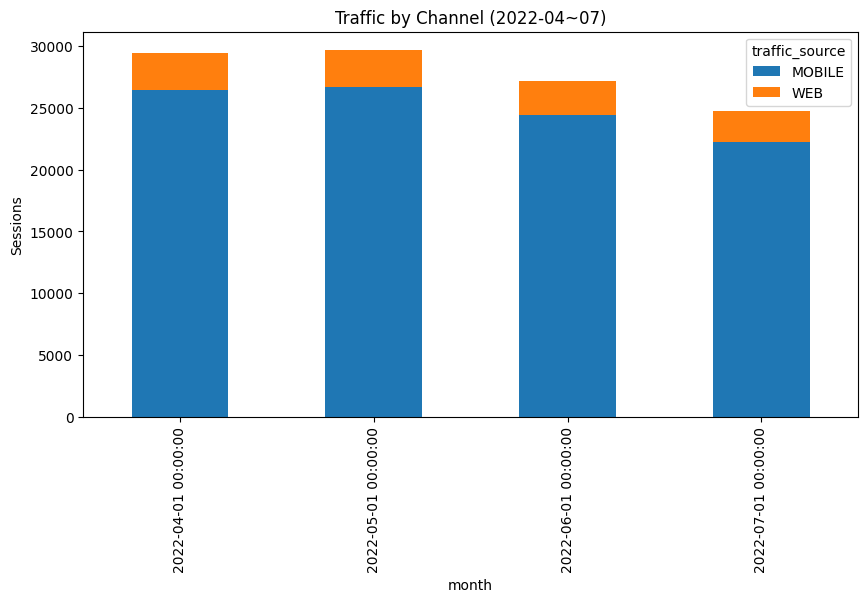

In [ ]:
#Traffic 감소 분석

kpi_by_channel = build_kpi(level='month', dims=['traffic_source'])
kpi_by_channel = kpi_by_channel[kpi_by_channel['month'].between('2022-04','2022-07')]

# 트렌드 그래프
import matplotlib.pyplot as plt
pivot = kpi_by_channel.pivot(index='month', columns='traffic_source', values='traffic')
pivot.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Traffic by Channel (2022-04~07)")
plt.ylabel("Sessions")

/tmp/ipython-input-1285447295.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(keys, dropna=False)
/tmp/ipython-input-1285447295.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(keys, dropna=False)


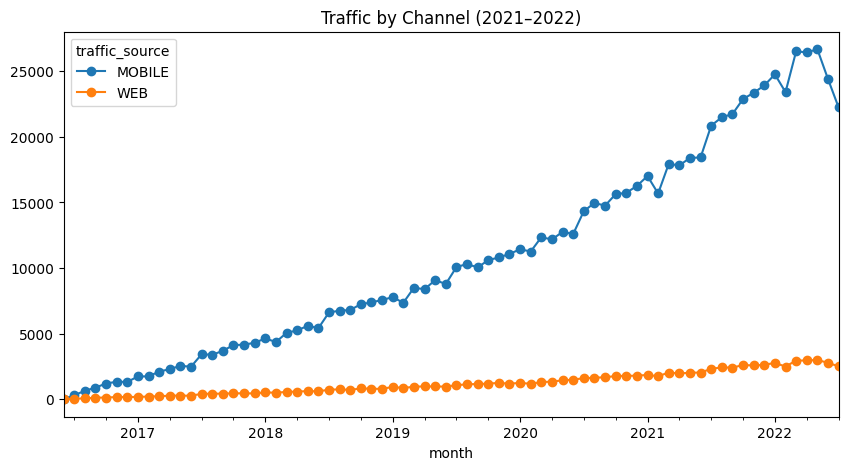

In [ ]:
#Step 1. 롱텀 트렌드 확인 (전년동기 + 올해 1~9월)

# Create kpi_by_channel_all for the entire period
kpi_by_channel_all = build_kpi(level='month', dims=['traffic_source'])

# Convert 'month' to datetime objects for proper plotting
kpi_by_channel_all['month'] = pd.to_datetime(kpi_by_channel_all['month'])

pivot_long = kpi_by_channel_all.pivot(index='month', columns='traffic_source', values='traffic')
pivot_long.plot(marker='o', figsize=(10,5))
plt.title("Traffic by Channel (2021–2022)")
plt.show()

/tmp/ipython-input-1285447295.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(keys, dropna=False)
/tmp/ipython-input-1285447295.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(keys, dropna=False)


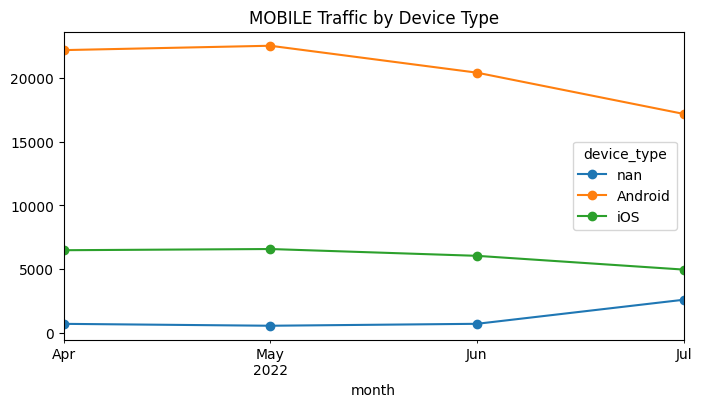

In [ ]:
#Step 2. 단기 원인 확정 (22년 4~7월 세부분석)

kpi_by_os = build_kpi(level='month', dims=['device_type'])

# Convert 'month' to datetime objects for filtering and plotting
kpi_by_os['month'] = pd.to_datetime(kpi_by_os['month'])

kpi_by_os[kpi_by_os['month'].between('2022-04-01','2022-07-31')].pivot(
    index='month', columns='device_type', values='traffic'
).plot(marker='o', figsize=(8,4))
plt.title("MOBILE Traffic by Device Type")
plt.show()

2. traffic 감소 유저 분석: 신규 vs 재방문

In [ ]:
#신규 유저 정의하기
import pandas as pd
from datetime import timedelta

# 신규 유저 기준일 (가입 후 30일 이내면 신규)
WINDOW_DAYS = 30

# 고객 정보 로드
customers = pd.read_csv('/content/drive/MyDrive/Fashion_E-commerce_Analysis_25/customer.csv', usecols=['customer_id','first_join_date'], dtype={'customer_id':'string'})
customers['first_join_date'] = pd.to_datetime(customers['first_join_date']).dt.tz_localize('UTC') # Localize to UTC

# Drop existing first_join_date columns in sess_first to avoid merge conflicts
sess_first = sess_first.drop(columns=[col for col in sess_first.columns if 'first_join_date' in col], errors='ignore')


# ① sess_first에 고객 가입일 붙이기
sess_first = sess_first.merge(customers, on='customer_id', how='left')

# Check columns after merge - there might be duplicate column names
print("Columns after merge:", sess_first.columns.tolist())

# If there's a duplicated 'first_join_date' column (e.g., 'first_join_date_y'), use the correct one
# Assuming the correct one from the 'customers' dataframe is the one we want.
# This might be named 'first_join_date_y' if there was already a 'first_join_date_x' in sess_first (unlikely in this case)
# or simply 'first_join_date' if no conflict. Let's check.

# If 'first_join_date' is not directly available, look for suffixed versions
if 'first_join_date' in sess_first.columns:
    join_date_col = 'first_join_date'
elif 'first_join_date_x' in sess_first.columns and 'first_join_date_y' in sess_first.columns:
     # This scenario is unlikely given the merge structure, but as a safeguard
     join_date_col = 'first_join_date_y' # Assuming 'y' comes from 'customers'
elif 'first_join_date_y' in sess_first.columns:
     join_date_col = 'first_join_date_y'
else:
    # If still not found, something is wrong with the merge or customer data
    raise KeyError("Could not find 'first_join_date' column in merged sess_first dataframe.")


# ② 가입일과 세션일 차이 계산
# Handle cases where the identified join_date_col might have NaT after the merge
valid_join_dates = sess_first[join_date_col].notna()
sess_first.loc[valid_join_dates, 'days_since_join'] = (sess_first.loc[valid_join_dates, 'session_time'] - sess_first.loc[valid_join_dates, join_date_col]).dt.days
sess_first['days_since_join'] = sess_first['days_since_join'].fillna(-1) # Use -1 or another indicator for sessions without a join date

# ③ 신규/기존 유저 구분
sess_first['is_new'] = sess_first['days_since_join'].between(0, WINDOW_DAYS)

# ④ 월 컬럼 (already done in previous step)
sess_first['month'] = sess_first['session_time'].dt.to_period('M').astype(str)

# ⑤ 월별 + 신규/기존 별 세션 수 계산
sess_kpi = (
    sess_first
    .groupby(['month','is_new'], observed=True)
    .agg(sessions=('session_id','nunique'),
         customers=('customer_id','nunique'))
    .reset_index()
    .pivot(index='month', columns='is_new', values=['sessions','customers'])
    .fillna(0)
)

# ⑥ 컬럼명 정리
sess_kpi.columns = [f"{metric}_{'new' if flag else 'ret'}" for metric, flag in sess_kpi.columns]
sess_kpi = sess_kpi.reset_index()

# ⑦ 신규 트래픽 비중 계산
sess_kpi['total_sessions'] = sess_kpi['sessions_new'] + sess_kpi['sessions_ret']
sess_kpi['new_share'] = sess_kpi['sessions_new'] / sess_kpi['total_sessions']
sess_kpi = sess_kpi.sort_values('month')

display(sess_kpi.tail(12))

Columns after merge: ['session_id', 'session_time', 'traffic_source', 'device_type', 'customer_id', 'date', 'week', 'month', 'first_join_date']


/tmp/ipython-input-224956392.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sess_first['month'] = sess_first['session_time'].dt.to_period('M').astype(str)


,month,sessions_ret,sessions_new,customers_ret,customers_new,total_sessions,new_share
62,2021-08,21763.0,2163.0,13684.0,1560.0,23926.0,0.090404
63,2021-09,22465.0,1683.0,14203.0,1231.0,24148.0,0.069695
64,2021-10,23749.0,1748.0,14734.0,1307.0,25497.0,0.068557
65,2021-11,24173.0,1762.0,15122.0,1292.0,25935.0,0.067939
66,2021-12,25606.0,940.0,15835.0,728.0,26546.0,0.035410
67,2022-01,25931.0,1607.0,15817.0,1152.0,27538.0,0.058356
68,2022-02,24128.0,1778.0,15269.0,1208.0,25906.0,0.068633
69,2022-03,27478.0,1998.0,16472.0,1215.0,29476.0,0.067784
70,2022-04,27386.0,2010.0,16185.0,1189.0,29396.0,0.068377
71,2022-05,28481.0,1203.0,16102.0,712.0,29684.0,0.040527


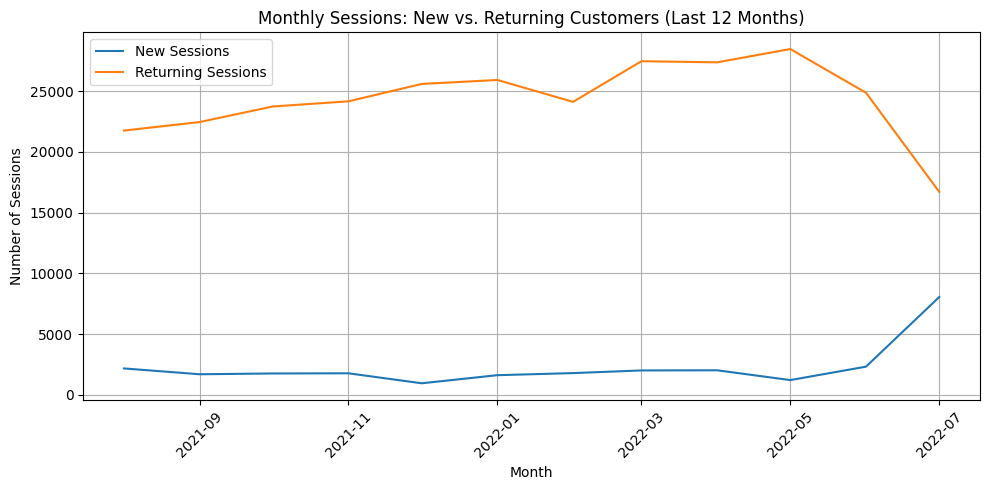

In [ ]:
import matplotlib.pyplot as plt

# Convert 'month' column back to datetime objects for plotting
sess_kpi['month'] = pd.to_datetime(sess_kpi['month'])

# Filter for the last 12 months
sess_kpi_last12 = sess_kpi.tail(12).copy()

plt.figure(figsize=(10, 5))
plt.plot(sess_kpi_last12['month'], sess_kpi_last12['sessions_new'], label='New Sessions')
plt.plot(sess_kpi_last12['month'], sess_kpi_last12['sessions_ret'], label='Returning Sessions')
plt.title('Monthly Sessions: New vs. Returning Customers (Last 12 Months)')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#3. CVR Analysis

In [ ]:
# CVR 분석을 위한 Funnel 단계 확인
print("=== Event 종류 (Funnel 단계) ===")
print(merged['event_name'].value_counts())
print("\n=== Unique Events ===")
print(sorted(merged['event_name'].unique()))

=== Event 종류 (Funnel 단계) ===
event_name
CLICK          2498038
HOMEPAGE       2487126
ADD_TO_CART    1937157
SCROLL         1663571
ITEM_DETAIL    1290396
SEARCH         1173266
BOOKING         852582
PROMO_PAGE      604931
ADD_PROMO       326535
Name: count, dtype: int64

=== Unique Events ===
['ADD_PROMO', 'ADD_TO_CART', 'BOOKING', 'CLICK', 'HOMEPAGE', 'ITEM_DETAIL', 'PROMO_PAGE', 'SCROLL', 'SEARCH']


In [ ]:
import pandas as pd
import numpy as np

# 0) 준비
merged['event_time'] = pd.to_datetime(merged['event_time'], errors='coerce')
merged['month'] = merged['event_time'].dt.to_period('M')

# 1) 단계 매핑
stage_map = {
    'HOMEPAGE': 'visit',
    'CLICK': 'visit',
    'SCROLL': 'explore',
    'SEARCH': 'explore',
    'ITEM_DETAIL': 'explore',
    'ADD_TO_CART': 'intent',
    'PROMO_PAGE': 'promo',
    'ADD_PROMO': 'promo',
    'BOOKING': 'conversion'
}
merged['stage'] = merged['event_name'].map(stage_map)

# 분석 기간(완전한 월만 쓰는 걸 추천)
period_mask = merged['month'].astype(str).between('2022-01','2022-07')
df = merged[period_mask & merged['stage'].notna()].copy()

# 2) 고객×월×단계별 '최초 발생 시각' 피벗
first_ts = (
    df.groupby(['customer_id','month','stage'])['event_time']
      .min()
      .unstack('stage')          # columns: visit/explore/intent/promo/conversion
)

# 누락 컬럼 보강
for col in ['visit','explore','intent','promo','conversion']:
    if col not in first_ts.columns:
        first_ts[col] = pd.NaT

first_ts = first_ts.reset_index()

# 3) 같은 달 내 '시간 순서'를 만족하는 고객만 연결
def to_bool(series):  # True/False로 변환
    return series.notna()

first_ts['has_visit']   = to_bool(first_ts['visit'])
first_ts['has_explore'] = to_bool(first_ts['explore'])   & (first_ts['explore']   >= first_ts['visit'])
first_ts['has_intent']  = to_bool(first_ts['intent'])    & (first_ts['intent']    >= first_ts['explore'])
# ===== 3️⃣ 브랜칭 퍼널 버전 =====
v  = first_ts['visit']
e  = first_ts['explore']
it = first_ts['intent']
pr = first_ts['promo']
cv = first_ts['conversion']

has_visit   = v.notna()
has_explore = e.notna() & (e >= v)

# intent: explore 있으면 intent >= explore, 없으면 visit 이후
has_intent  = it.notna() & (
                 (e.notna() & (it >= e)) |
                 (e.isna()  & (it >= v))
              )

# promo: intent 후 promo 발생
has_promo   = pr.notna() & has_intent & (pr >= it)

# conversion: intent 이후 발생하면 인정 (promo optional)
has_conv_after_intent = cv.notna() & has_intent & (cv >= it)

# overall: visit 이후 conversion
has_conv_after_visit = cv.notna() & has_visit & (cv >= v)

# 월별 집계
g = first_ts.assign(
        has_visit=has_visit,
        has_explore=has_explore,
        has_intent=has_intent,
        has_promo=has_promo,
        has_conv_after_intent=has_conv_after_intent,
        has_conv_after_visit=has_conv_after_visit
    ).groupby('month')

out = pd.DataFrame({
    'visit_users': g['has_visit'].sum(),
    'explore_users': g['has_explore'].sum(),
    'intent_users': g['has_intent'].sum(),
    'promo_users': g['has_promo'].sum(),
    'conv_after_intent': g['has_conv_after_intent'].sum(),
    'conv_after_visit': g['has_conv_after_visit'].sum(),
}).reset_index()

# 단계별 전환율 계산
out['visit_to_explore']  = out['explore_users'] / out['visit_users'].replace(0, np.nan)
out['explore_to_intent'] = out['intent_users']  / out['explore_users'].replace(0, np.nan)
out['intent_to_promo']   = out['promo_users']   / out['intent_users'].replace(0, np.nan)
out['intent_to_conv']    = out['conv_after_intent'] / out['intent_users'].replace(0, np.nan)
out['overall_cvr']       = out['conv_after_visit'] / out['visit_users'].replace(0, np.nan)

print(out[['month','visit_users','visit_to_explore','explore_to_intent',
           'intent_to_promo','intent_to_conv','overall_cvr']])


/tmp/ipython-input-2498520150.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged['month'] = merged['event_time'].dt.to_period('M')


     month  visit_users  visit_to_explore  explore_to_intent  intent_to_promo  \
0  2022-01        19493          0.717847           0.545344         0.425501   
1  2022-02        18777          0.721255           0.545965         0.413308   
2  2022-03        19700          0.733706           0.540612         0.424622   
3  2022-04        19222          0.743835           0.533221         0.459864   
4  2022-05        18250          0.763014           0.520790         0.462769   
5  2022-06        15653          0.791669           0.496207         0.484144   
6  2022-07         9543          0.802368           0.450307         0.546984   

   intent_to_conv  overall_cvr  
0        0.646573     0.732622  
1        0.644847     0.726793  
2        0.661889     0.752995  
3        0.691238     0.778015  
4        0.688638     0.809973  
5        0.761425     0.896314  
6        0.775522     0.920151  


/tmp/ipython-input-2134924190.py:37: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  d['month'] = d['event_time'].dt.to_period('M')


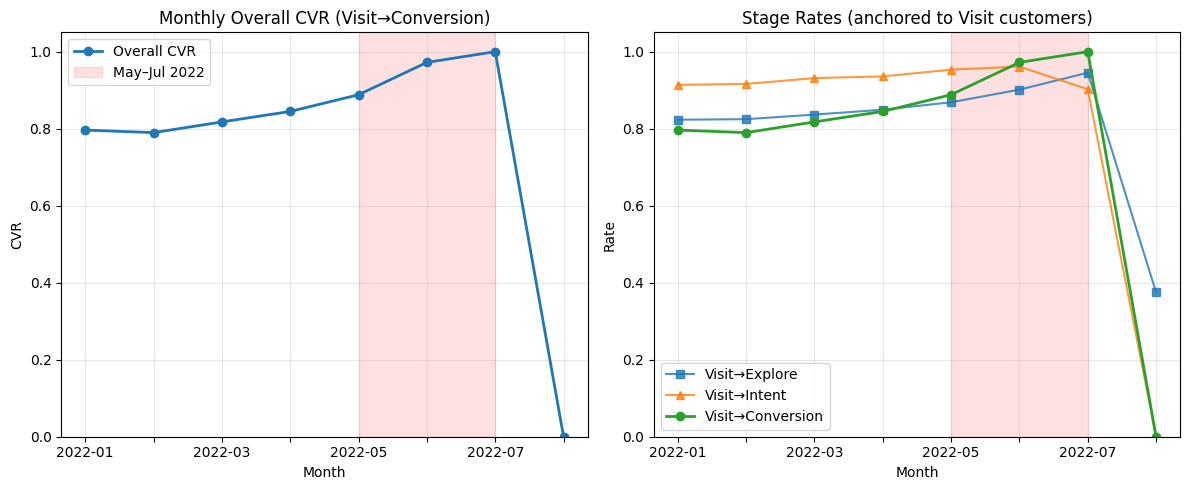

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 0) 준비
merged['event_time'] = pd.to_datetime(merged['event_time'], errors='coerce')

# 1) 퍼널 매핑 그대로 사용
funnel_map = {
    'HOMEPAGE': 'visit',
    'CLICK': 'visit',
    'SCROLL': 'explore',
    'SEARCH': 'explore',
    'ITEM_DETAIL': 'explore',
    'ADD_TO_CART': 'intent',
    'PROMO_PAGE': 'promo',
    'ADD_PROMO': 'promo',
    'BOOKING': 'conversion'
}
merged['funnel_stage'] = merged['event_name'].map(funnel_map)

# 2) 월/세그먼트/고객 단위로 "그 달에 해당 스테이지를 했는가(1/0)" 형태 만들기
def build_monthly_funnel(df, start='2022-01-01', end='2022-12-31', seg=None):
    d = df.copy()

    if seg is not None:
        # seg 예: {'device':'Android', 'user_type':'returning'}
        for k,v in seg.items():
            d = d[d[k].str.lower()==v.lower()] if d[k].dtype=='O' else d[d[k]==v]

    # Localize start and end dates to UTC to match merged['event_time']
    start_dt = pd.to_datetime(start).tz_localize('UTC')
    end_dt = pd.to_datetime(end).tz_localize('UTC')

    d = d[(d['event_time']>=start_dt) & (d['event_time']<=end_dt)]
    d['month'] = d['event_time'].dt.to_period('M')

    # (월, 고객, 스테이지)별로 그 달에 해당 스테이지가 있었는지(1) pivot
    flags = (
        d.dropna(subset=['customer_id','funnel_stage'])
         .assign(flag=1)
         .groupby(['month','customer_id','funnel_stage'])['flag']
         .max()                               # 그 달에 1번이라도 했으면 1
         .unstack('funnel_stage', fill_value=0)
         .reset_index()
    )

    # 누락 스테이지 방어
    for c in ['visit','explore','intent','promo','conversion']:
        if c not in flags.columns:
            flags[c] = 0

    # 같은 달에 visit한 고객 집합을 분모로 고정
    base = flags[flags['visit']==1].copy()

    # 분모(visit 고객 수)
    denom = base.groupby('month')['customer_id'].nunique().rename('visit_users')

    # 각 스테이지를 한 고객 수 (visit 고객들 중)
    stage_counts = base.groupby('month')[['explore','intent','promo','conversion']].sum()

    out = pd.concat([denom, stage_counts], axis=1).reset_index()
    # CVR 계산 (분모=해당 달 visit 고객 수)
    out['cvr_visit_to_explore']    = np.where(out['visit_users']>0, out['explore']   / out['visit_users'], np.nan)
    out['cvr_visit_to_intent']     = np.where(out['visit_users']>0, out['intent']    / out['visit_users'], np.nan)
    out['cvr_visit_to_promo']      = np.where(out['visit_users']>0, out['promo']     / out['visit_users'], np.nan)
    out['overall_cvr']             = np.where(out['visit_users']>0, out['conversion']/ out['visit_users'], np.nan)

    # 정렬/표기 정리
    out = out.sort_values('month')
    out['month_str'] = out['month'].astype(str)
    return out

# 3) 전체 CVR (월별)
overall = build_monthly_funnel(merged, start='2022-01-01', end='2022-12-31')

# 4) 시각화 — 라벨 간격/축 범위/하이라이트 정리
plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(overall['month_str'], overall['overall_cvr'], marker='o', linewidth=2, label='Overall CVR')
ax1.set_title('Monthly Overall CVR (Visit→Conversion)')
ax1.set_xlabel('Month'); ax1.set_ylabel('CVR')
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)
# x축 라벨 간격 줄이기
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if n % 2 != 0: label.set_visible(False)
# 5–7월 하이라이트
ax1.axvspan('2022-05', '2022-07', color='red', alpha=0.12, label='May–Jul 2022')
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.plot(overall['month_str'], overall['cvr_visit_to_explore'], marker='s', label='Visit→Explore', alpha=0.8)
ax2.plot(overall['month_str'], overall['cvr_visit_to_intent'],  marker='^', label='Visit→Intent',  alpha=0.8)
ax2.plot(overall['month_str'], overall['overall_cvr'],          marker='o', label='Visit→Conversion', linewidth=2)
ax2.set_title('Stage Rates (anchored to Visit customers)')
ax2.set_xlabel('Month'); ax2.set_ylabel('Rate'); ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.3)
for n, label in enumerate(ax2.xaxis.get_ticklabels()):
    if n % 2 != 0: label.set_visible(False)
ax2.axvspan('2022-05', '2022-07', color='red', alpha=0.12)
ax2.legend()

plt.tight_layout()
plt.show()

데이터 확인:
     month  visit_users  visit_to_explore  explore_to_intent  intent_to_promo  \
0  2022-01        19493          0.717847           0.545344         0.425501   
1  2022-02        18777          0.721265           0.545965         0.413308   
2  2022-03        19700          0.733706           0.540612         0.424622   
3  2022-04        19222          0.743635           0.532221         0.459864   
4  2022-05        18250          0.763014           0.520790         0.492759   
5  2022-06        19653          0.791689           0.498207         0.484144   
6  2022-07         9543          0.802368           0.450307         0.546984   

   intent_to_conv  overall_cvr  
0        0.646573     0.732622  
1        0.644847     0.726733  
2        0.661889     0.752995  
3        0.691238     0.778015  
4        0.680638     0.809473  
5        0.751425     0.896314  
6        0.779522     0.920151  

=== 퍼널 단계별 평균 전환율 ===
Visit Users: 1.0000 (100.00%)
Visit to Explore: 0.7534 (

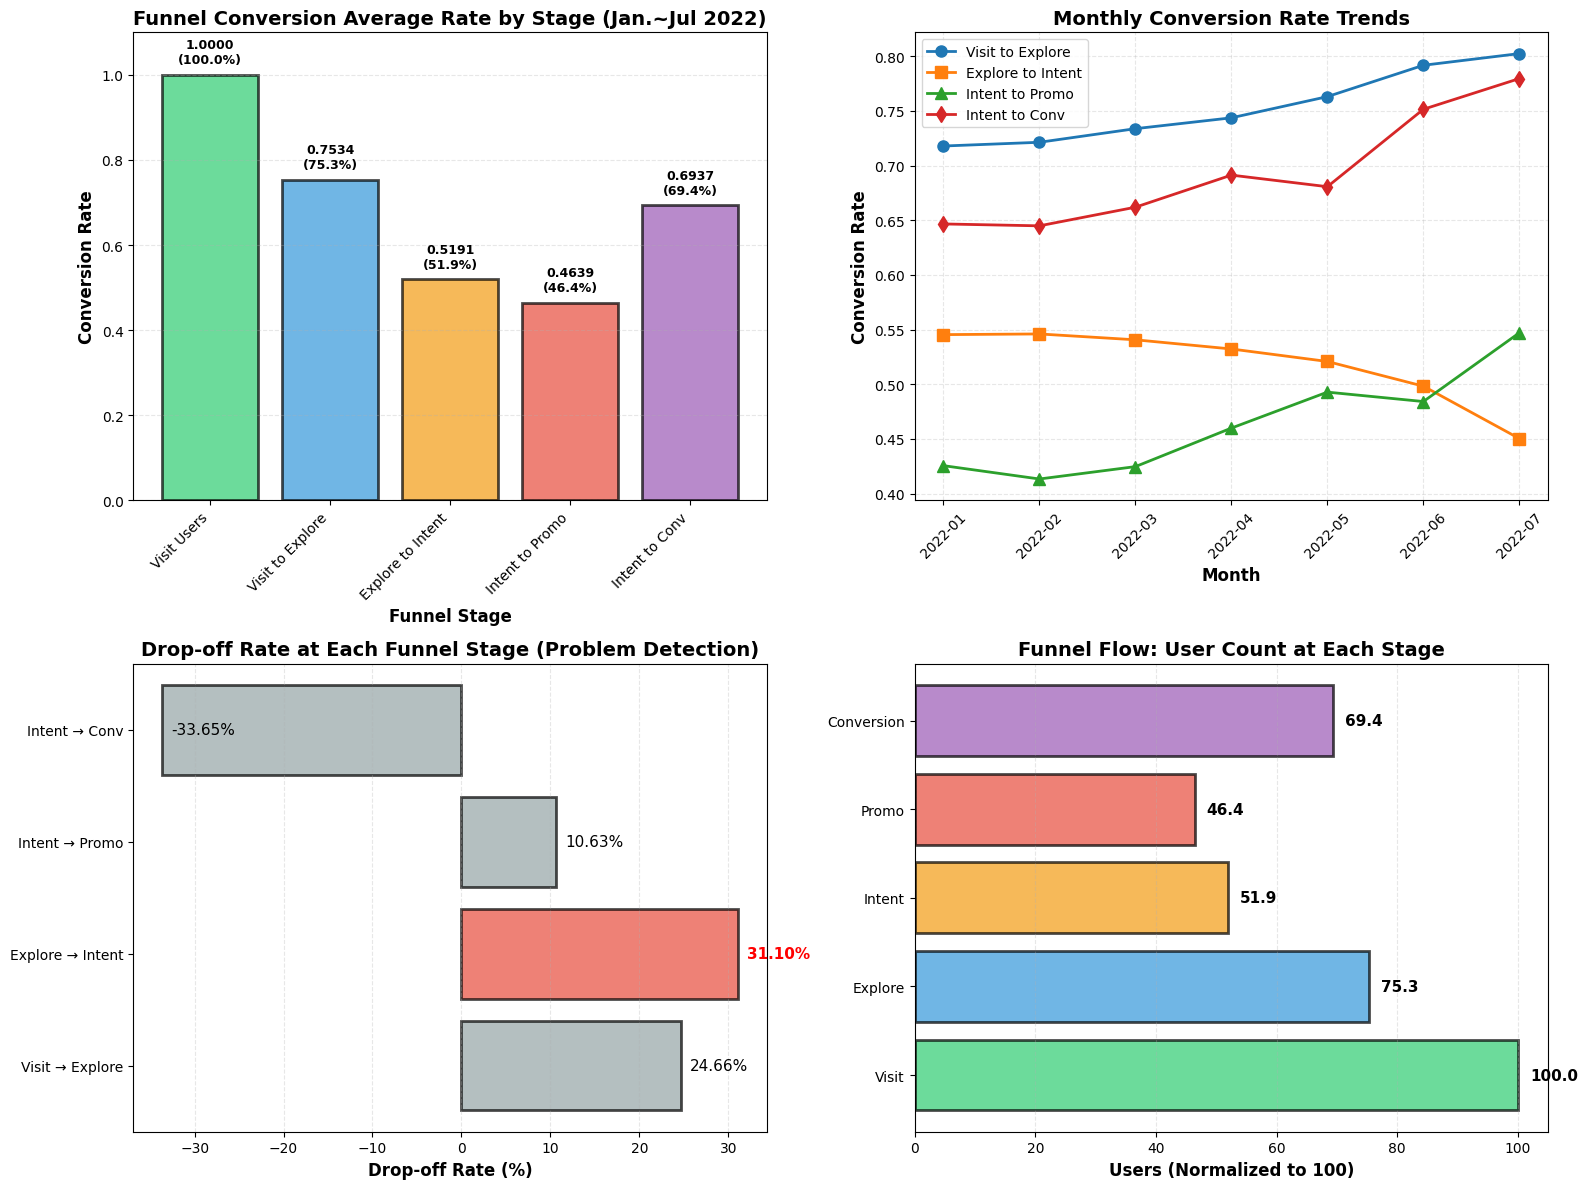


🔍 퍼널 분석 결과 및 문제점

📊 각 단계별 드롭오프율 (손실률):
  - Visit → Explore: 24.66%
  - Explore → Intent: 31.10%
  - Intent → Promo: 10.63%
  - Intent → Conv: -33.65%

⚠️  가장 큰 문제 단계: Explore → Intent
   손실률: 31.10%

💡 개선 방안:
  1. 상품 탐색 경험 개선
  2. 상품 추천 알고리즘 개선
  3. 검색 기능 향상



In [ ]:
# 사용자가 제공한 데이터 기반으로 시각화
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 사용자 데이터 생성 (이미지에서 발취)
data = {
    'month': ['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07'],
    'visit_users': [19493, 18777, 19700, 19222, 18250, 19653, 9543],
    'visit_to_explore': [0.717847, 0.721265, 0.733706, 0.743635, 0.763014, 0.791689, 0.802368],
    'explore_to_intent': [0.545344, 0.545965, 0.540612, 0.532221, 0.520790, 0.498207, 0.450307],
    'intent_to_promo': [0.425501, 0.413308, 0.424622, 0.459864, 0.492759, 0.484144, 0.546984],
    'intent_to_conv': [0.646573, 0.644847, 0.661889, 0.691238, 0.680638, 0.751425, 0.779522],
    'overall_cvr': [0.732622, 0.726733, 0.752995, 0.778015, 0.809473, 0.896314, 0.920151]
}

df = pd.DataFrame(data)
print("데이터 확인:")
print(df)

# 퍼널 단계별 평균 전환율
funnel_stages = {
    'Visit Users': 1.0,
    'Visit to Explore': df['visit_to_explore'].mean(),
    'Explore to Intent': df['explore_to_intent'].mean(),
    'Intent to Promo': df['intent_to_promo'].mean(),
    'Intent to Conv': df['intent_to_conv'].mean(),

}

print("\n=== 퍼널 단계별 평균 전환율 ===")
for stage, rate in funnel_stages.items():
    print(f"{stage}: {rate:.4f} ({rate*100:.2f}%)")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) 퍼널 단계별 전환율
ax1 = axes[0, 0]
stages = list(funnel_stages.keys())
rates = list(funnel_stages.values())
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#9b59b6', '#34495e']

bars = ax1.bar(range(len(stages)), rates, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_xlabel('Funnel Stage', fontsize=12, fontweight='bold')
ax1.set_ylabel('Conversion Rate', fontsize=12, fontweight='bold')
ax1.set_title('Funnel Conversion Average Rate by Stage (Jan.~Jul 2022)', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(stages)))
ax1.set_xticklabels(stages, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1.1])

for i, (bar, rate) in enumerate(zip(bars, rates)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{rate:.4f}\n({rate*100:.1f}%)',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2) 월별 전환율 추이
ax2 = axes[0, 1]
months = df['month']
x = np.arange(len(months))

ax2.plot(x, df['visit_to_explore'], marker='o', label='Visit to Explore', linewidth=2, markersize=8)
ax2.plot(x, df['explore_to_intent'], marker='s', label='Explore to Intent', linewidth=2, markersize=8)
ax2.plot(x, df['intent_to_promo'], marker='^', label='Intent to Promo', linewidth=2, markersize=8)
ax2.plot(x, df['intent_to_conv'], marker='d', label='Intent to Conv', linewidth=2, markersize=8)


ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
ax2.set_ylabel('Conversion Rate', fontsize=12, fontweight='bold')
ax2.set_title('Monthly Conversion Rate Trends', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(months, rotation=45)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

# 3) 각 단계별 드롭오프율
ax3 = axes[1, 0]
dropoff_rates = {
    'Visit → Explore': (1 - funnel_stages['Visit to Explore']) * 100,
    'Explore → Intent': (1 - funnel_stages['Explore to Intent'] / funnel_stages['Visit to Explore']) * 100,
    'Intent → Promo': (1 - funnel_stages['Intent to Promo'] / funnel_stages['Explore to Intent']) * 100,
    'Intent → Conv': (1 - funnel_stages['Intent to Conv'] / funnel_stages['Explore to Intent']) * 100
}

labels = list(dropoff_rates.keys())
values = list(dropoff_rates.values())

# 가장 큰 드롭오프율 찾기
max_idx = values.index(max(values))
bar_colors = ['#e74c3c' if i == max_idx else '#95a5a6' for i in range(len(values))]

bars3 = ax3.barh(labels, values, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_xlabel('Drop-off Rate (%)', fontsize=12, fontweight='bold')
ax3.set_title('Drop-off Rate at Each Funnel Stage (Problem Detection)', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars3, values)):
    color = 'red' if i == max_idx else 'black'
    weight = 'bold' if i == max_idx else 'normal'
    ax3.text(val + 1, bar.get_y() + bar.get_height()/2.,
             f'{val:.2f}%',
             ha='left', va='center', fontsize=11, fontweight=weight, color=color)

# 4) 퍼널 플로우
ax4 = axes[1, 1]
funnel_users = {
    'Visit': 100,
    'Explore': 100 * funnel_stages['Visit to Explore'],
    'Intent': 100 * funnel_stages['Explore to Intent'],
    'Promo': 100 * funnel_stages['Intent to Promo'],
    'Conversion': 100 * funnel_stages['Intent to Conv']
}

f_labels = list(funnel_users.keys())
f_values = list(funnel_users.values())
y_pos = np.arange(len(f_labels))

bars4 = ax4.barh(y_pos, f_values, color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#9b59b6'],
                 alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_yticks(y_pos)
ax4.set_yticklabels(f_labels)
ax4.set_xlabel('Users (Normalized to 100)', fontsize=12, fontweight='bold')
ax4.set_title('Funnel Flow: User Count at Each Stage', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars4, f_values)):
    ax4.text(val + 2, bar.get_y() + bar.get_height()/2.,
             f'{val:.1f}',
             ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 문제점 분석
print("\n" + "="*70)
print("🔍 퍼널 분석 결과 및 문제점")
print("="*70)

print("\n📊 각 단계별 드롭오프율 (손실률):")
for label, rate in dropoff_rates.items():
    print(f"  - {label}: {rate:.2f}%")

max_dropoff_label = max(dropoff_rates, key=dropoff_rates.get)
max_dropoff_value = dropoff_rates[max_dropoff_label]

print(f"\n⚠️  가장 큰 문제 단계: {max_dropoff_label}")
print(f"   손실률: {max_dropoff_value:.2f}%")

print("\n💡 개선 방안:")
if 'Visit' in max_dropoff_label:
    print("  1. 랜딩 페이지 개선")
    print("  2. 첫 화면 UX 최적화")
    print("  3. 로딩 속도 개선")
elif 'Explore' in max_dropoff_label:
    print("  1. 상품 탐색 경험 개선")
    print("  2. 상품 추천 알고리즘 개선")
    print("  3. 검색 기능 향상")
elif 'Promo' in max_dropoff_label and 'Intent' in max_dropoff_label:
    print("  1. 프로모션 노출 전략 개선")
    print("  2. 타겟팅 할인 정보 제공")
    print("  3. 개인화 프로모션 제안")
elif 'Conv' in max_dropoff_label:
    print("  1. 결제 프로세스 간소화")
    print("  2. 장바구니 이탈 방지")
    print("  3. 결제 수단 다양화")

print("\n" + "="*70)

/tmp/ipython-input-1732761358.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged['month'] = merged['event_time'].dt.to_period('M').astype(str)


📊 Session-based 퍼널 분석 결과 (2022년)
     month  visit_sessions  visit_to_explore  explore_to_intent  \
0  2022-01           31994          0.744827           0.464624   
1  2022-02           30067          0.745801           0.467535   
2  2022-03           33684          0.760955           0.455680   
3  2022-04           33461          0.770509           0.443643   
4  2022-05           33547          0.783885           0.431380   
5  2022-06           30545          0.808381           0.410943   
6  2022-07           27260          0.846772           0.366807   

   intent_to_conv  overall_cvr  
0        2.138367     0.740014  
1        2.093857     0.730103  
2        2.174572     0.754038  
3        2.250656     0.769343  
4        2.360455     0.798194  
5        2.542821     0.844721  
6        2.801465     0.870139  

✅ 이제 build_kpi의 CVR과 일관성 있는 분석입니다!


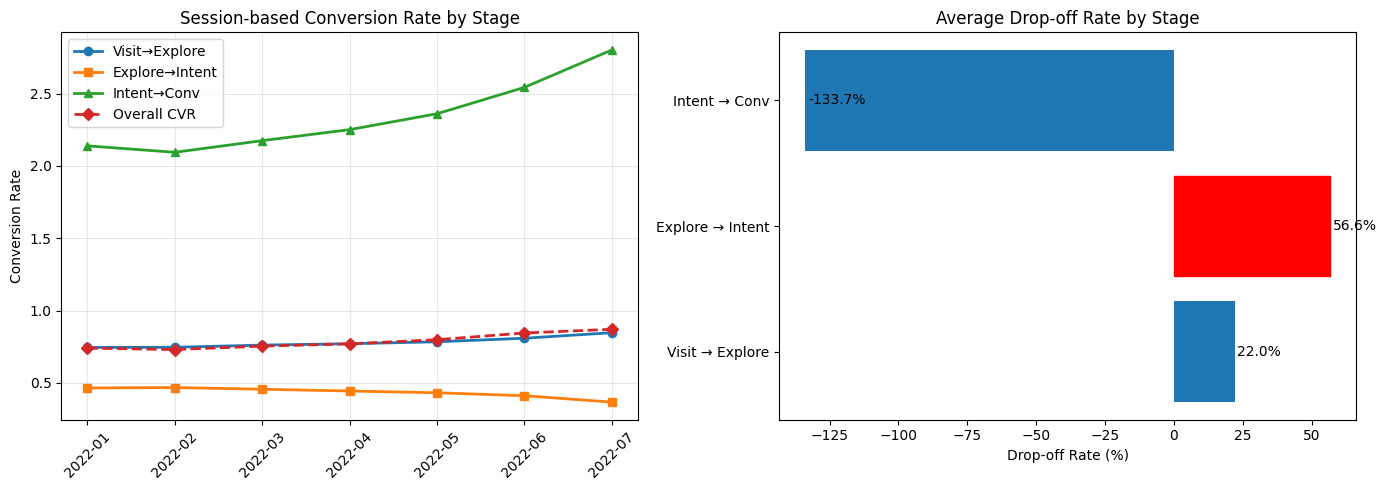


🔍 build_kpi CVR과 비교:
Session-based Overall CVR (2022-07): 87.01%
→ build_kpi의 CVR과 동일한 기준으로 계산됨!


In [ ]:
# ============================================
# Session-based 퍼널 분석 (build_kpi와 일관성 유지)
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 준비: 월별 컬럼 추가
merged['month'] = merged['event_time'].dt.to_period('M').astype(str)

# 2) 퍼널 단계 매핑
funnel_map = {
    'HOMEPAGE': 'visit',
    'CLICK': 'visit',
    'SCROLL': 'explore',
    'SEARCH': 'explore',
    'ITEM_DETAIL': 'explore',
    'ADD_TO_CART': 'intent',
    'PROMO_PAGE': 'promo',
    'ADD_PROMO': 'promo',
    'BOOKING': 'conversion'
}
merged['stage'] = merged['event_name'].map(funnel_map)

# 3) 분석 기간 필터
period_mask = merged['month'].between('2022-01', '2022-07')
df = merged[period_mask & merged['stage'].notna()].copy()

# 4) 세션별 × 월별 × 단계별 첫 발생 시각
first_ts_session = (
    df.groupby(['session_id', 'month', 'stage'])['event_time']
      .min()
      .unstack('stage')  # columns: visit/explore/intent/promo/conversion
)

# 누락 컬럼 보강
for col in ['visit', 'explore', 'intent', 'promo', 'conversion']:
    if col not in first_ts_session.columns:
        first_ts_session[col] = pd.NaT

first_ts_session = first_ts_session.reset_index()

# 5) 시간 순서 기반 퍼널 도달 여부 계산
v = first_ts_session['visit']
e = first_ts_session['explore']
it = first_ts_session['intent']
cv = first_ts_session['conversion']

has_visit = v.notna()
has_explore = e.notna() & (e >= v)
has_intent = it.notna() & (
    (e.notna() & (it >= e)) | (e.isna() & (it >= v))
)
has_conversion = cv.notna() & has_visit & (cv >= v)

# 6) 월별 집계
g = first_ts_session.assign(
    has_visit=has_visit,
    has_explore=has_explore,
    has_intent=has_intent,
    has_conversion=has_conversion
).groupby('month')

session_funnel = pd.DataFrame({
    'visit_sessions': g['has_visit'].sum(),
    'explore_sessions': g['has_explore'].sum(),
    'intent_sessions': g['has_intent'].sum(),
    'conversion_sessions': g['has_conversion'].sum(),
}).reset_index()

# 7) 단계별 전환율 계산 (Session-based)
session_funnel['visit_to_explore'] = (
    session_funnel['explore_sessions'] /
    session_funnel['visit_sessions'].replace(0, np.nan)
)
session_funnel['explore_to_intent'] = (
    session_funnel['intent_sessions'] /
    session_funnel['explore_sessions'].replace(0, np.nan)
)
session_funnel['intent_to_conv'] = (
    session_funnel['conversion_sessions'] /
    session_funnel['intent_sessions'].replace(0, np.nan)
)
session_funnel['overall_cvr'] = (
    session_funnel['conversion_sessions'] /
    session_funnel['visit_sessions'].replace(0, np.nan)
)

# 8) 결과 출력
print("📊 Session-based 퍼널 분석 결과 (2022년)")
print("="*70)
print(session_funnel[['month', 'visit_sessions', 'visit_to_explore',
                       'explore_to_intent', 'intent_to_conv', 'overall_cvr']])
print("\n✅ 이제 build_kpi의 CVR과 일관성 있는 분석입니다!")

# 9) 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 좌측: 월별 전환율 트렌드
ax1 = axes[0]
x = range(len(session_funnel))
ax1.plot(x, session_funnel['visit_to_explore'], marker='o',
         label='Visit→Explore', linewidth=2)
ax1.plot(x, session_funnel['explore_to_intent'], marker='s',
         label='Explore→Intent', linewidth=2)
ax1.plot(x, session_funnel['intent_to_conv'], marker='^',
         label='Intent→Conv', linewidth=2)
ax1.plot(x, session_funnel['overall_cvr'], marker='D',
         label='Overall CVR', linewidth=2, linestyle='--')
ax1.set_xticks(x)
ax1.set_xticklabels(session_funnel['month'], rotation=45)
ax1.set_title('Session-based Conversion Rate by Stage')
ax1.set_ylabel('Conversion Rate')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 우측: Drop-off Rate
ax2 = axes[1]
avg_funnel = session_funnel[['visit_to_explore', 'explore_to_intent',
                              'intent_to_conv']].mean()
dropoff_rates = {
    'Visit → Explore': (1 - avg_funnel['visit_to_explore']) * 100,
    'Explore → Intent': (1 - avg_funnel['explore_to_intent']) * 100,
    'Intent → Conv': (1 - avg_funnel['intent_to_conv']) * 100
}
bars = ax2.barh(list(dropoff_rates.keys()), list(dropoff_rates.values()))
bars[np.argmax(list(dropoff_rates.values()))].set_color('red')
ax2.set_xlabel('Drop-off Rate (%)')
ax2.set_title('Average Drop-off Rate by Stage')
for i, (k, v) in enumerate(dropoff_rates.items()):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

# 10) build_kpi CVR과 비교
print("\n🔍 build_kpi CVR과 비교:")
print(f"Session-based Overall CVR (2022-07): {session_funnel.iloc[-1]['overall_cvr']:.2%}")
print("→ build_kpi의 CVR과 동일한 기준으로 계산됨!")
